Load packages and some data from the server

In [1]:
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn
import scipy
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.inspection import permutation_importance

In [2]:
basepath = '/Volumes/data/MPV/projects/SAB_Orebro/study3/data/'
metadata_clean = pd.read_excel(basepath + 'metadata_clean.xlsx', engine='calamine')

In [3]:
persistent_bacteremia = pd.read_csv(basepath + 'Set_persistent_bacteremia/df.Rtab', sep = '\t')
persistent_bacteremia['sex_binary'] = [1 if i == 'Male' else 0 for i in persistent_bacteremia['Sex'].to_list()]

The classes are unbalanced which means we will need to take this into account when evaluating metrics

In [4]:
gwas_results = pd.read_excel(basepath + 'Set_persistent_bacteremia/treeWAS/fasttree_gubbins/gene_treewas.xlsx')

In [5]:
gwas_results.shape

(8404, 21)

In [6]:
gene_absence_presence_matrix = pd.read_csv(basepath + 'Set_full/roary/gene_presence_absence.Rtab', sep = '\t')

The matrix is in gene x sample with the first column being name of genes, we will transpose it and add genes as column names.

In [7]:
genes = gene_absence_presence_matrix.Gene
values = gene_absence_presence_matrix.iloc[0:, gene_absence_presence_matrix.columns != 'Gene'] # iloc can both be used with numerical and boolean indexing
gene_matrix = values.T
gene_matrix.columns = genes

Subset the matrix with the bacteremia samples

In [8]:
samples_in_bacteremia = gene_matrix.loc[np.isin(gene_matrix.index, persistent_bacteremia.sample_name)]
informative_genes = [i for i in genes if gene_matrix.loc[:, i].value_counts().count() > 1] # filter out non informative genes
samples_in_bacteremia = samples_in_bacteremia.loc[:, np.isin(samples_in_bacteremia.columns, informative_genes)]

In [343]:
informative_genes[0]

'group_1248'

In [340]:
len(informative_genes)

7053

Select rows in the gwas results dataframe (gene x gwas_variables) where any of the p values from treewas are significant

In [12]:
significant_rows = gwas_results[['terminal_pvalue', 'simultaneous_pvalue', 'subsequent_pvalue']] <= 0.05/gwas_results.shape[0]
significant_rows = np.any(significant_rows.to_numpy(), axis=1)
significant_df = gwas_results.loc[significant_rows, :]

One sample needs its name fixed, verified with others that it's the same as without the underscore

In [14]:
samples_in_bacteremia.rename(index={'SSAB19166_1':'SSAB19166'}, inplace=True)
significant_matrix = samples_in_bacteremia.loc[:, np.isin(samples_in_bacteremia.columns, significant_df.ID)]
persistent_bacteremia.rename(columns={'Persistant_bacteremia':'persistent_bacteremia'}, inplace=True)

In [15]:
persistent_bacteremia_variable_subset = persistent_bacteremia[['persistent_bacteremia', 'original_sample_name', 'sex_binary', 'Age', 'Comorbidity_uCCI', 'Community_aquired', 'Nosocomial','Health_care_associated']]
persistent_bacteremia_variable_subset.set_index('original_sample_name', inplace=True)

In [16]:
joined_data_frame = persistent_bacteremia_variable_subset.join(significant_matrix) # joins on index by default

Split the data into 80% training and 20% testing. We since there's a class imbalance we also make sure we aren't underselecting the positive class (persistent bacteremia) in our test set

In [18]:
joined_data_frame.persistent_bacteremia.value_counts()/joined_data_frame.persistent_bacteremia.shape[0]

persistent_bacteremia
0    0.640264
1    0.359736
Name: count, dtype: float64

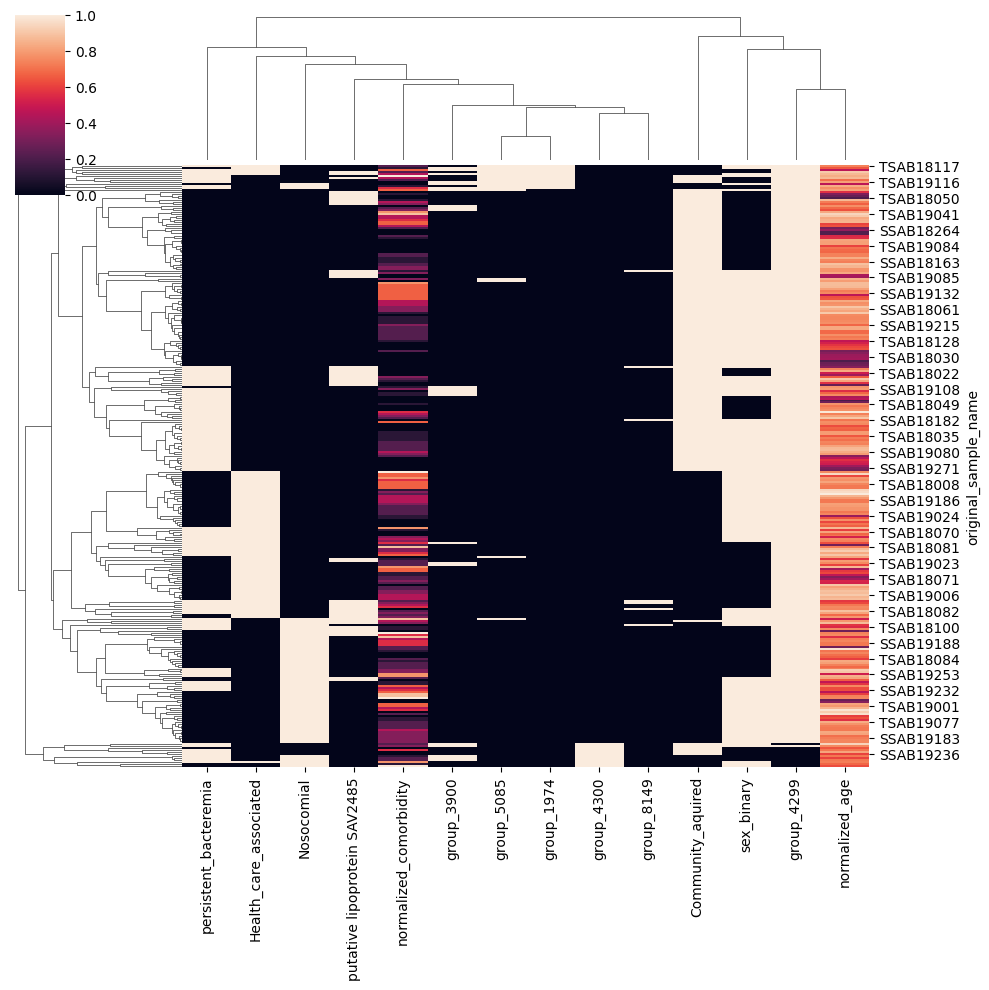

In [19]:
heatmap_df = joined_data_frame.copy()
heatmap_df['normalized_age'] = heatmap_df.Age/max(heatmap_df.Age)
heatmap_df['normalized_comorbidity'] = heatmap_df.Comorbidity_uCCI/max(heatmap_df.Comorbidity_uCCI)
#seaborn.heatmap(heatmap_df.drop('Age', axis=1), vmin = 0, vmax = 1)
seaborn.clustermap(heatmap_df.drop(['Age', 'Comorbidity_uCCI'], axis=1))

<Axes: >

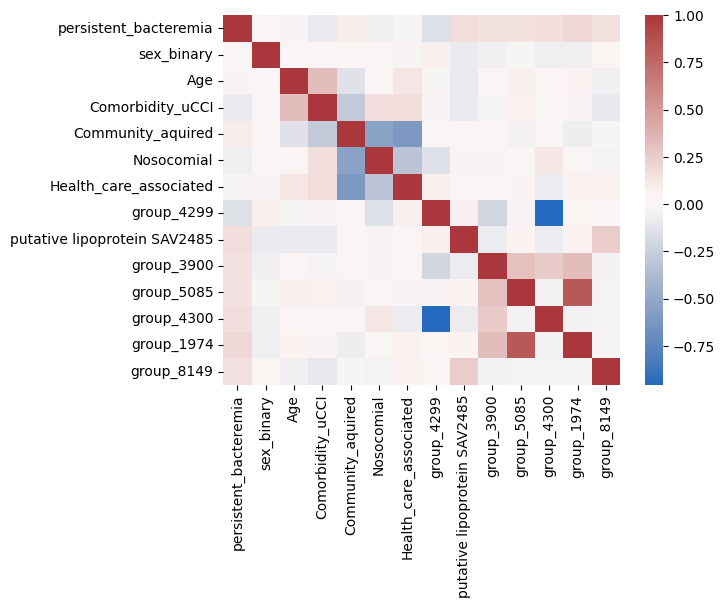

In [94]:
heatmap_df_corr = heatmap_df.drop(['normalized_age', 'normalized_comorbidity'], axis=1).corr() # dropping nomralized columns doesnt change the result as it's just scalar multiplication but for easier reading of names
seaborn.heatmap(heatmap_df_corr, cmap='vlag')

In [191]:
random_state = 666
np.random.seed(random_state) # for reproduction

In [20]:
test_frac = 0.2
test_dfs = {}
train_dfs = {}
classes = np.unique(joined_data_frame.persistent_bacteremia)
for i in classes:
    sub_df = joined_data_frame.loc[joined_data_frame.persistent_bacteremia == i, :]
    n_sub = sub_df.shape[0]
    sub_indices_shuffled = np.random.choice(a = np.arange(n_sub), size = n_sub, replace = False)
    n_test = np.intc(np.ceil(n_sub*test_frac))
    test_idx = sub_indices_shuffled[0:n_test]
    train_idx = sub_indices_shuffled[n_test:]
    test_dfs[i] = sub_df.iloc[test_idx, :]
    train_dfs[i] = sub_df.iloc[train_idx, :]



In [21]:
train_df_conc = pd.concat([train_dfs[i] for i in train_dfs.keys()])
test_df_conc = pd.concat([test_dfs[i] for i in test_dfs.keys()])


In [22]:
sanity_check = pd.concat([train_df_conc, test_df_conc])
sanity_check.sort_index().equals(joined_data_frame)

True

In [23]:
trainx = train_df_conc.loc[:, train_df_conc.columns != 'persistent_bacteremia'].to_numpy()
trainy = train_df_conc.loc[:, train_df_conc.columns == 'persistent_bacteremia'].to_numpy().ravel()

testx = test_df_conc.loc[:, test_df_conc.columns != 'persistent_bacteremia'].to_numpy()
testy = test_df_conc.loc[:, test_df_conc.columns == 'persistent_bacteremia'].to_numpy().ravel()
test_model = sklearn.ensemble.RandomForestClassifier(n_estimators = 1000, class_weight='balanced')
test_model.fit(trainx, trainy)

RandomForestClassifier(class_weight='balanced', n_estimators=1000)

In [24]:
def return_sklearn_metrics(fitted_predictor_instance, x, y):
    predicted_y = fitted_predictor_instance.predict(x)
    probs_y = fitted_predictor_instance.predict_proba(x)[:, 1]
    metrics = {'accuracy':accuracy_score(y, predicted_y),
               'balanced_accuracy':balanced_accuracy_score(y, predicted_y),
               'recall':recall_score(y, predicted_y),
               'precision':precision_score(y, predicted_y),
               'f1_macro':f1_score(y, predicted_y, average='macro'),
               'roc_auc':roc_auc_score(y, probs_y),
               'mcc':matthews_corrcoef(y, predicted_y)}
    return metrics

In [25]:
predicted_train = test_model.predict(trainx)

In [26]:
return_sklearn_metrics(test_model, trainx, trainy)

{'accuracy': 0.987603305785124,
 'balanced_accuracy': 0.9878012606599926,
 'recall': 0.9885057471264368,
 'precision': 0.9772727272727273,
 'f1': 0.9865742024965326,
 'roc_auc': 0.9996662958843159,
 'mcc': 0.9731878829071282}

In [33]:
print(f1_score(trainy, predicted_train, average='binary'))
print(f1_score(trainy, predicted_train, average='micro'))
print(f1_score(trainy, predicted_train, average='macro'))
print(sklearn.metrics.precision_score(trainy, predicted_train))
print(sklearn.metrics.recall_score(trainy, predicted_train))

0.9828571428571429
0.987603305785124
0.9865742024965326
0.9772727272727273
0.9885057471264368


In [28]:
recall = np.logical_and(trainy == 1, predicted_train == 1).sum()/trainy[trainy==1].shape[0]
precision = np.logical_and(trainy == 1, predicted_train == 1).sum()/predicted_train[predicted_train==1].shape[0]
f1_test = 2*precision*recall/(precision+recall)
true_positives = np.logical_and(trainy == 1, predicted_train == 1).sum()
false_positives = np.logical_and(trainy == 0, predicted_train == 1).sum()
false_negatives = np.logical_and(trainy == 1, predicted_train == 0).sum()
f1_test2 = 2*true_positives/(2*true_positives + false_positives + false_negatives)
print(recall, precision, f1_test, f1_test2)

0.9885057471264368 0.9772727272727273 0.9828571428571428 0.9828571428571429


In [272]:
cv_test = sklearn.model_selection.cross_val_score(test_model, trainx, trainy, scoring='f1_macro')
cv_test

array([0.5       , 0.59466912, 0.53062275, 0.54459203, 0.53125   ])

In [273]:
rf_params = {'criterion': ['gini', 'entropy', 'log_loss'],
             'min_samples_split': [2, 5, 10],
             'min_samples_leaf': [1, 2, 4],
            'n_estimators':[50, 100, 200, 500],
            'max_depth':[2, 3, 10, 30]}

grid = GridSearchCV(RandomForestClassifier(class_weight='balanced', random_state=666),
                    rf_params,
                    scoring={'f1':'f1_macro','mcc':'matthews_corrcoef'}, 
                    cv=5,
                    refit='f1', 
                    n_jobs=8)

In [274]:
grid.fit(trainx, trainy)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=666),
             n_jobs=8,
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [2, 3, 10, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200, 500]},
             refit='f1',
             scoring={'f1': 'f1_macro', 'mcc': 'matthews_corrcoef'})

In [275]:
pd.DataFrame(grid.cv_results_).shape

(432, 26)

In [326]:
print(grid.best_score_)
print(grid.best_params_)
cv_grid = sklearn.model_selection.cross_val_score(grid.best_estimator_, trainx, trainy, scoring='matthews_corrcoef')
print(np.mean(cv_grid), ' mcc')
cv_grid = sklearn.model_selection.cross_val_score(grid.best_estimator_, trainx, trainy, scoring='f1_macro')
print(np.mean(cv_grid), ' f1 macro')
cv_grid = sklearn.model_selection.cross_val_score(grid.best_estimator_, trainx, trainy, scoring='balanced_accuracy')
print(np.mean(cv_grid), ' balanced acc')

0.6359882985038432
{'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
0.2929409926050965  mcc
0.6359882985038432  f1 macro
0.6407653383934218  balanced acc


In [202]:
grid.best_estimator_.feature_importances_

array([0.03996971, 0.18537861, 0.14074208, 0.04631158, 0.03265226,
       0.02163816, 0.09530315, 0.07689245, 0.02363154, 0.05563458,
       0.13453583, 0.08758379, 0.05972625])

In [241]:
rf_params = {'criterion': ['gini', 'entropy', 'log_loss'],
             'min_samples_split': np.arange(2, 10),
             'min_samples_leaf': np.arange(1, 4),
             'n_estimators':np.arange(100, 1000),
             'max_depth':scipy.stats.randint(2, 10)}

random_grid = RandomizedSearchCV(RandomForestClassifier(bootstrap = True, class_weight = 'balanced', random_state=random_state),
                    rf_params,
                    scoring={'f1':'f1_macro','mcc':'matthews_corrcoef'}, 
                    cv=5,
                    refit='mcc', 
                    n_jobs=8,
                    n_iter=1000,          
                    random_state=random_state)

In [242]:
random_grid.fit(trainx, trainy)

RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    random_state=666),
                   n_iter=1000, n_jobs=8,
                   param_distributions={'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x136855b50>,
                                        'min_samples_leaf': array([1, 2, 3]),
                                        'min_samples_split': array([2, 3, 4, 5, 6, 7, 8, 9]),
                                        'n...
       932, 933, 934, 935, 936, 937, 938, 939, 940, 941, 942, 943, 944,
       945, 946, 947, 948, 949, 950, 951, 952, 953, 954, 955, 956, 957,
       958, 959, 960, 961, 962, 963, 964, 965, 966, 967, 968, 969, 970,
       971, 972, 973, 974, 975, 976, 977, 978, 979, 980, 981, 982, 983,
       984, 985, 986, 987, 988, 989, 990, 991, 992, 993, 994, 995, 996,
       997, 998, 999])},
                   random_state=666, refit='mcc',
                   scoring={'f1': 'f1_macro', 'mcc': 'matthews_corrcoef'})

In [243]:
print(random_grid.best_score_)
print(random_grid.best_params_)
print(random_grid.best_estimator_)
cv_random = sklearn.model_selection.cross_val_score(random_grid.best_estimator_, trainx, trainy, scoring='matthews_corrcoef')
print(cv_random)
cv_random = sklearn.model_selection.cross_val_score(random_grid.best_estimator_, trainx, trainy, scoring='f1_macro')
print(cv_random)

0.28872543827439917
{'criterion': 'log_loss', 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 7, 'n_estimators': 801}
RandomForestClassifier(class_weight='balanced', criterion='log_loss',
                       max_depth=2, min_samples_split=7, n_estimators=801,
                       random_state=666)
[0.30918404 0.33396525 0.40042672 0.26368468 0.13636651]
[0.64612422 0.66666667 0.6998557  0.61352657 0.54028169]


In [162]:
rf_params_samples = {'criterion': ['gini', 'entropy', 'log_loss'],
             'min_samples_split': np.arange(2, 20),
             'min_samples_leaf': np.arange(2, 8),
             'n_estimators':np.arange(10, 1000),
             #'max_depth':scipy.stats.randint(2, 30),
             'max_samples': scipy.stats.uniform(0.1, 0.9)} # samples from lower bound to lower bound + scale

random_grid_with_samples = RandomizedSearchCV(RandomForestClassifier(bootstrap = True, class_weight = 'balanced'),
                    rf_params_samples,
                    scoring={'f1':'f1_macro','mcc':'matthews_corrcoef'}, 
                    cv=5,
                    refit='mcc', 
                    n_jobs=8,
                     n_iter=1000)

In [163]:
random_grid_with_samples.fit(trainx, trainy)

RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(class_weight='balanced'),
                   n_iter=1000, n_jobs=8,
                   param_distributions={'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_samples': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x1361d4bd0>,
                                        'min_samples_leaf': array([2, 3, 4, 5, 6, 7]),
                                        'min_samples_split': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13...
       920, 921, 922, 923, 924, 925, 926, 927, 928, 929, 930, 931, 932,
       933, 934, 935, 936, 937, 938, 939, 940, 941, 942, 943, 944, 945,
       946, 947, 948, 949, 950, 951, 952, 953, 954, 955, 956, 957, 958,
       959, 960, 961, 962, 963, 964, 965, 966, 967, 968, 969, 970, 971,
       972, 973, 974, 975, 976, 977, 978, 979, 980, 981, 982, 983, 984,
       985, 986, 987, 988, 989, 990, 991, 992, 993, 994, 995, 996, 997,
       998, 999])},
                   refit='mcc',
                   scoring={'f1': 'f1_macro', 'mcc': 'matthews_corrcoef'})

In [209]:
cv_random_samples = sklearn.model_selection.cross_val_score(random_grid_with_samples.best_estimator_, trainx, trainy, scoring='matthews_corrcoef')
print(cv_random_samples)
cv_random_samples = sklearn.model_selection.cross_val_score(random_grid_with_samples.best_estimator_, trainx, trainy, scoring='f1_macro')
print(cv_random_samples)
print(random_grid_with_samples.best_score_)
print(random_grid_with_samples.best_params_)

[0.25514974 0.2483852  0.15859048 0.19566687 0.17604841]
[0.66372549 0.62878788 0.63567362 0.56442831 0.58003088]
0.29685965439002177
{'criterion': 'log_loss', 'max_samples': 0.5285319973558079, 'min_samples_leaf': 2, 'min_samples_split': 17, 'n_estimators': 33}


In [208]:
#scipy.stats.randint(2,10).rvs(100)

In [319]:
rf_params = {'criterion': ['gini', 'entropy', 'log_loss'],
             'min_samples_split': [2, 5, 10],
             'min_samples_leaf': [1, 2, 4],
            'n_estimators':[50, 100, 200, 500],
            'max_depth':[2, 3, 10, 30]}

grid_no_snp = GridSearchCV(RandomForestClassifier(class_weight='balanced', random_state=666),
                    rf_params,
                    scoring={'f1':'f1_weighted','mcc':'matthews_corrcoef'}, 
                    cv=5,
                    refit='f1', 
                    n_jobs=8)
grid_no_snp.fit(trainx[:, 0:6], trainy)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=666),
             n_jobs=8,
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [2, 3, 10, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200, 500]},
             refit='f1',
             scoring={'f1': 'f1_weighted', 'mcc': 'matthews_corrcoef'})

In [327]:
print(grid_no_snp.best_score_)
print(grid_no_snp.best_params_)
cv_grid = sklearn.model_selection.cross_val_score(grid_no_snp.best_estimator_, trainx[:, 0:6], trainy, scoring='matthews_corrcoef')
print(np.mean(cv_grid), ' mcc')
cv_grid = sklearn.model_selection.cross_val_score(grid_no_snp.best_estimator_, trainx[:, 0:6], trainy, scoring='f1_macro')
print(np.mean(cv_grid), ' f1 macro')
cv_grid = sklearn.model_selection.cross_val_score(grid_no_snp.best_estimator_, trainx[:, 0:6], trainy, scoring='balanced_accuracy')
print(np.mean(cv_grid), ' balanced acc')


0.5571889976180099
{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
0.031302044333047827  mcc
0.5052296689956799  f1 macro
0.5160657811511702  balanced acc


TODO: check permutation importances and compare, maybe evaluate on the test set

Investigate permutation importances

In [316]:
r_snp = permutation_importance(grid.best_estimator_, trainx, trainy, n_repeats = 30, random_state = random_state, scoring = 'f1_macro')
pd.Series(r_snp.importances_mean, index = train_df_conc.columns[1:])

sex_binary                      0.020853
Age                             0.033469
Comorbidity_uCCI                0.042393
Community_aquired               0.021414
Nosocomial                      0.012697
Health_care_associated          0.001998
group_4299                      0.005996
putative lipoprotein SAV2485    0.050451
group_3900                      0.000832
group_5085                     -0.003298
group_4300                      0.012705
group_1974                      0.015212
group_8149                      0.012132
dtype: float64

In [317]:
r_no_snp = permutation_importance(grid_no_snp.best_estimator_, trainx[:, 0:6], trainy, n_repeats = 30, random_state = random_state, scoring = 'f1_macro')
pd.Series(r_no_snp.importances_mean, index=train_df_conc.columns[1:7].to_list())

sex_binary                0.209112
Age                       0.380106
Comorbidity_uCCI          0.339240
Community_aquired         0.129291
Nosocomial                0.076515
Health_care_associated    0.064921
dtype: float64

In [330]:
return_sklearn_metrics(grid.best_estimator_, trainx, trainy)

{'accuracy': 0.7355371900826446,
 'balanced_accuracy': 0.6826103077493512,
 'recall': 0.4942528735632184,
 'precision': 0.6825396825396826,
 'f1': 0.6908582834331338,
 'roc_auc': 0.7538746755654431,
 'mcc': 0.39937784497929946}

In [331]:
return_sklearn_metrics(grid.best_estimator_, testx, testy)

{'accuracy': 0.6229508196721312,
 'balanced_accuracy': 0.5664335664335665,
 'recall': 0.36363636363636365,
 'precision': 0.47058823529411764,
 'f1': 0.5665739882607352,
 'roc_auc': 0.585081585081585,
 'mcc': 0.14230180488055505}

In [333]:
return_sklearn_metrics(grid_no_snp.best_estimator_, testx[:, 0:6], testy)

{'accuracy': 0.5573770491803278,
 'balanced_accuracy': 0.49533799533799533,
 'recall': 0.2727272727272727,
 'precision': 0.35294117647058826,
 'f1': 0.4911955514365153,
 'roc_auc': 0.4463869463869463,
 'mcc': -0.009986091570565268}

In [323]:
train_dfs.keys()

dict_keys([0, 1])